<a href="https://colab.research.google.com/github/ramin40/actor-critic-method-Cartpole/blob/main/actor_critic_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# importing necessary libraries

In [3]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers

# specifying constants

In [4]:
seed=123
tf.random.set_seed(seed)
env=gym.make('CartPole-v0')
env.seed(seed)
max_step_per_episode=10000
gamma=0.99
eps=np.finfo(np.float32).eps.item()

# creating actor-critic network

In [5]:
num_actions=2
num_hidden_units=128
num_input_states=4

input=layers.Input(shape=(4,))
common=layers.Dense(num_hidden_units,activation='relu')(input)
action_probs=layers.Dense(num_actions,activation='softmax')(common)
state_value=layers.Dense(1)(common)
actor_critic_model=tf.keras.models.Model(input,[action_probs,state_value])
actor_critic_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          640         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2)            258         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1)            129         dense[0][0]                      
Total params: 1,027
Trainable params: 1,027
Non-trainable params: 0
__________________________

In [7]:
running_reward=0
optimizer=tf.keras.optimizers.Adam(learning_rate=0.01)
huber_loss=tf.keras.losses.Huber()
state_value_in_each_timestep=[]
action_in_each_timestep=[]
reward_in_each_timestep=[]
episode_counter=0
reward_during_episodes=[]
while True:


  
  state=env.reset()
  episode_reward=0
  with tf.GradientTape() as tape:
    
    for spisode in range(max_step_per_episode):
      
      # converting state to tensor for eager execution
      state=tf.convert_to_tensor(state)
      state=tf.expand_dims(state,0)
      # predictinge probability of each action and estimated value of state
      predicted_action_prob,value_state=actor_critic_model(state)
      state_value_in_each_timestep.append(value_state[0,0])
      # choosing action according probability of each actions 
      # this choosing method satisfys exploration for problem
      selected_action=np.random.choice(num_actions,p=np.squeeze(predicted_action_prob))
      action_in_each_timestep.append(tf.math.log(predicted_action_prob[0, selected_action]))
      # take step
      state,reward,done,_=env.step(selected_action)
      episode_reward+=reward
      reward_in_each_timestep.append(reward)

      if done:
        break
    
    running_reward=0.05*episode_reward+(1-0.05)*running_reward
    reward_during_episodes.append(running_reward)
    # calculating actual states value for calculating 
    # loss of critic
    actual_returns=[]
    discounted_sum=0
    for r in reward_in_each_timestep[::-1]:
      discounted_sum= r+ gamma*discounted_sum
      actual_returns.insert(0,discounted_sum)
    # normalizing targets
    actual_returns=np.array(actual_returns)
    actual_returns=(actual_returns-np.mean(actual_returns))/(np.std(actual_returns)+eps)
    actual_returns=actual_returns.tolist()
    # history
    history=zip(action_in_each_timestep,state_value_in_each_timestep,actual_returns)
    actor_loss=[]
    critic_loss=[]
    for log_prob,value,ret in history:
      diff=ret - value
      actor_loss.append(-1*log_prob*diff)
      critic_loss.append(
          huber_loss(tf.expand_dims(value, 0),tf.expand_dims(ret, 0)))
    total_loss=sum(actor_loss)+sum(critic_loss)
    state_value_in_each_timestep.clear()
    action_in_each_timestep.clear()
    reward_in_each_timestep.clear()
    grades=tape.gradient(total_loss,actor_critic_model.trainable_variables)
    optimizer.apply_gradients(zip(grades,actor_critic_model.trainable_variables))
    episode_counter += 1
  if episode_counter % 10 == 0:
    
    template = "running reward: {:.2f} at episode {}"
    print(template.format(running_reward, episode_counter))

  if running_reward > 195:  # Condition to consider the task solved
    print("Solved at episode {}!".format(episode_counter))
    break

running reward: 67.52 at episode 10
running reward: 80.08 at episode 20
running reward: 106.05 at episode 30
running reward: 117.26 at episode 40
running reward: 126.38 at episode 50
running reward: 141.60 at episode 60
running reward: 151.39 at episode 70
running reward: 136.27 at episode 80
running reward: 118.69 at episode 90
running reward: 108.76 at episode 100
running reward: 128.94 at episode 110
running reward: 154.40 at episode 120
running reward: 146.08 at episode 130
running reward: 119.17 at episode 140
running reward: 107.47 at episode 150
running reward: 142.51 at episode 160
running reward: 138.88 at episode 170
running reward: 130.29 at episode 180
running reward: 132.19 at episode 190
running reward: 149.90 at episode 200
running reward: 170.00 at episode 210
running reward: 182.04 at episode 220
running reward: 189.25 at episode 230
running reward: 193.56 at episode 240
Solved at episode 245!


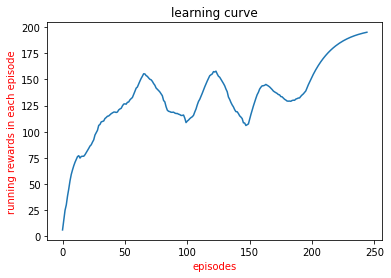

In [10]:
plt.plot(range(episode_counter),reward_during_episodes)
plt.title('learning curve')
plt.xlabel('episodes',c='r')
plt.ylabel('running rewards in each episode',c='r')
plt.savefig('actor-critic-cartpole',dpi=1000)
plt.show()

## Visualizations
In early stages of training:
![Imgur](https://i.imgur.com/5gCs5kH.gif)

In later stages of training:
![Imgur](https://i.imgur.com/5ziiZUD.gif)
